
TRAIN SET:
NORMAL: 1341 images
PNEUMONIA: 3875 images

VAL SET:
NORMAL: 8 images
PNEUMONIA: 8 images

TEST SET:
NORMAL: 234 images
PNEUMONIA: 390 images


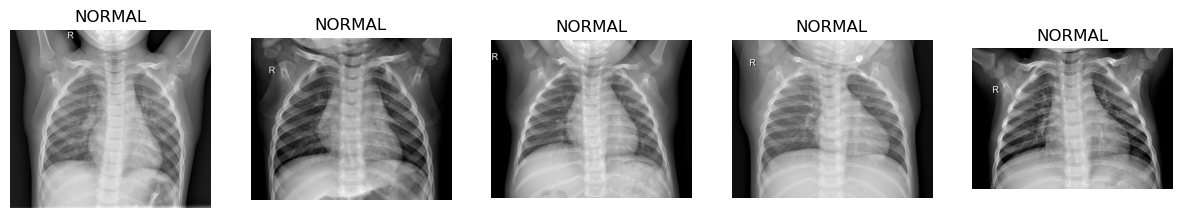

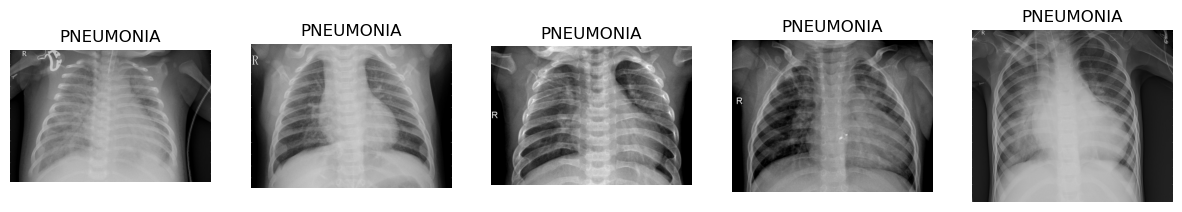

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Path to dataset
data_dir = 'E:\ML\Pneumonia_Detection\chest_xray'  # adjust to your path

# Display image counts
for split in ['train', 'val', 'test']:
    print(f"\n{split.upper()} SET:")
    for label in ['NORMAL', 'PNEUMONIA']:
        folder_path = os.path.join(data_dir, split, label)
        count = len(os.listdir(folder_path))
        print(f"{label}: {count} images")

# Display a few image samples
def display_samples(dataset_path, category, num_images=5):
    category_path = os.path.join(dataset_path, 'train', category)
    images = os.listdir(category_path)[:num_images]
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(images):
        img_path = os.path.join(category_path, img)
        img_tensor = tf.keras.preprocessing.image.load_img(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img_tensor, cmap='gray')
        plt.title(category)
        plt.axis('off')
    plt.show()

display_samples(data_dir, 'NORMAL')
display_samples(data_dir, 'PNEUMONIA')


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define parameters
img_size = (150, 150)  # Resize images
batch_size = 32

# Data augmentation settings
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill missing pixels
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale validation data

# Load train dataset
train_dataset = train_datagen.flow_from_directory(
    'E:/ML/Pneumonia_Detection/chest_xray/train',
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',  # Ensure images are grayscale
    class_mode='binary'  # Binary classification (NORMAL vs PNEUMONIA)
)

# Load validation dataset
val_dataset = val_datagen.flow_from_directory(
    'E:/ML/Pneumonia_Detection/chest_xray/val',
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary'
)

# Load test dataset
test_dataset = val_datagen.flow_from_directory(
    'E:/ML/Pneumonia_Detection/chest_xray/test',
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Found 5216 files belonging to 2 classes.


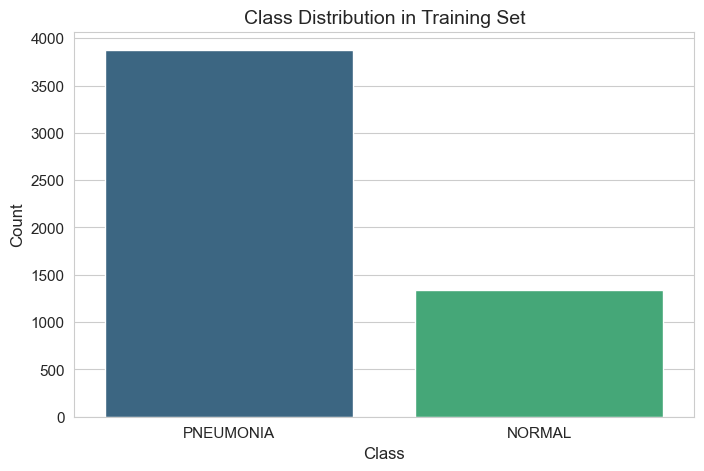

In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd

# Set the dataset directory path (ensure valid path formatting)
data_dir = r'E:\ML\Pneumonia_Detection\chest_xray'  # Raw string format recommended

# Load the training dataset with grayscale handling
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'train'),
    image_size=(150, 150),
    batch_size=32,
    label_mode='binary'
)

# Extract labels safely
labels = []
for _, y in train_ds:
    labels.extend(y.numpy())

# Convert labels using class mapping safely
class_names = train_ds.class_names  # ['NORMAL', 'PNEUMONIA']
mapped_labels = [class_names[int(label)] if int(label) < len(class_names) else 'Unknown' for label in labels]

# Create a DataFrame for better handling
df = pd.DataFrame(mapped_labels, columns=['Class'])

# Set figure size for better visualization
plt.figure(figsize=(8, 5))

# Improved visualization using Seaborn's aesthetic styling
sns.set_style('whitegrid')
sns.countplot(data=df, x='Class', palette='viridis')

plt.title("Class Distribution in Training Set", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Show the plot
plt.show()


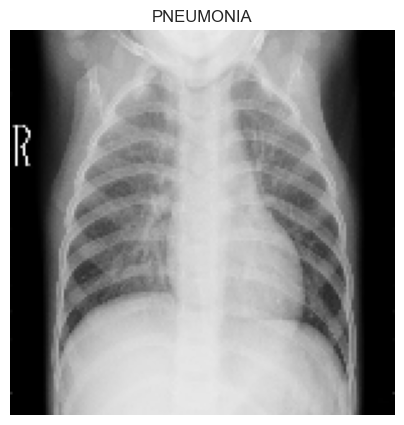

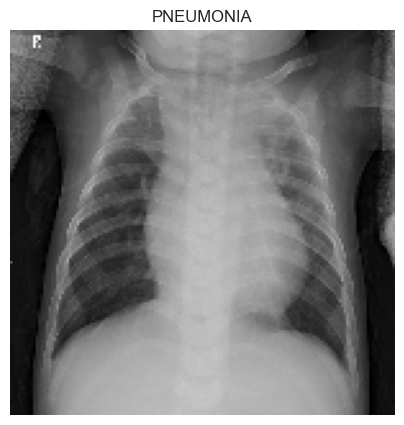

In [4]:
import matplotlib.pyplot as plt

# Get class labels
class_names = train_ds.class_names

# Convert the first batch to NumPy for easy indexing
for images, labels_batch in train_ds.take(1):  # Take the first batch
    first_image = images[0].numpy()
    first_label = labels_batch[0].numpy()

# Preview first image
plt.figure(figsize=(5, 5))
plt.imshow(first_image.astype("uint8"), cmap='gray')  # Grayscale
plt.title(class_names[int(first_label)])
plt.axis('off')
plt.show()

# Get last batch properly
last_batch = None
for images, labels_batch in train_ds:
    last_batch = (images, labels_batch)  # Store the last batch

# Extract last image safely
if last_batch:
    last_image = last_batch[0][-1].numpy()  # Last image in last batch
    last_label = last_batch[1][-1].numpy()  # Last label in last batch

    # Preview last image
    plt.figure(figsize=(5, 5))
    plt.imshow(last_image.astype("uint8"), cmap='gray')  # Grayscale
    plt.title(class_names[int(last_label)])
    plt.axis('off')
    plt.show()


In [17]:
def convert_to_grayscale(image, label):
    image = tf.image.rgb_to_grayscale(image)  # Convert RGB to grayscale
    return image, label

# Apply grayscale conversion to datasets
train_ds = train_ds.map(convert_to_grayscale)
val_ds = val_ds.map(convert_to_grayscale)
test_ds = test_ds.map(convert_to_grayscale)


In [6]:
import tensorflow as tf

# Define input layer separately
inputs = tf.keras.Input(shape=(150, 150, 1))  # Grayscale input

# CNN Architecture
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Build the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,827,905 (18.42 MB)

 Trainable params: 4,827,905 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'val'),
    image_size=(150, 150),
    batch_size=32,
    label_mode='binary'
)


Found 16 files belonging to 2 classes.


In [16]:
assert train_ds is not None, "train_ds not defined!"
assert val_ds is not None, "val_ds not defined!"
assert test_ds is not None, "test_ds not defined!"


In [11]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'test'),
    image_size=(150, 150),
    batch_size=32,
    label_mode='binary'
)


Found 624 files belonging to 2 classes.


In [12]:
print(train_ds)
print(val_ds)
print(test_ds)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>


In [14]:
for images, labels in train_ds.take(1):  # Take one batch
    print(f"Image shape: {images.shape}")  # Should be (batch_size, height, width, channels)


Image shape: (32, 150, 150, 3)


In [19]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [20]:
# Define dataset directory path
data_dir = r'E:/ML/Pneumonia_Detection/chest_xray'  # Use raw string to avoid path issues

# Load datasets with RGB format
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'train'),
    image_size=(150, 150),
    batch_size=32,
    color_mode='rgb',  # Ensures images remain RGB
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'val'),
    image_size=(150, 150),
    batch_size=32,
    color_mode='rgb',
    label_mode='binary'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'test'),
    image_size=(150, 150),
    batch_size=32,
    color_mode='rgb',
    label_mode='binary'
)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=10,  # Small rotation
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    shear_range=0.1,  # Shear transformation
    zoom_range=0.1,  # Random zoom
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill missing pixels
)

# Load augmented training dataset
train_ds = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Validation & Test (only rescale, no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

val_ds = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'val'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_ds = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [22]:
labels = []
for _, y in train_ds:
    labels.extend(y.numpy())

# Convert to class names
class_names = train_ds.class_names
mapped_labels = [class_names[int(label)] for label in labels]

# Plot class distribution
sns.set_style('whitegrid')
sns.countplot(x=mapped_labels, palette='viridis')
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [23]:
# Define CNN architecture
inputs = tf.keras.Input(shape=(150, 150, 3))  # Keep RGB input

x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Compile the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
    ]
)


c:\Users\vjais\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.7869 - loss: 0.4822

163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 676ms/step - accuracy: 0.7872 - loss: 0.4815 - val_accuracy: 0.8125 - val_loss: 0.4779
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.8823 - loss: 0.2699

163/163 ━━━━━━━━━━━━━━━━━━━━ 124s 763ms/step - accuracy: 0.8824 - loss: 0.2698 - val_accuracy: 0.8125 - val_loss: 0.3968
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 118s 725ms/step - accuracy: 0.9121 - loss: 0.2296 - val_accuracy: 0.8125 - val_loss: 0.4792
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.9255 - loss: 0.1976 - val_accuracy: 0.7500 - val_loss: 0.5878
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 606s 4s/step - accuracy: 0.9217 - loss: 0.1891 - val_accuracy: 0.7500 - val_loss: 0.5119
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 131s 802ms/step - accuracy: 0.9379 - loss: 0.1686 - val_accuracy: 0.7500 - val_loss: 0.4400
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 430s 3s/step - accuracy: 0.9362 - loss: 0.1678 - val_accuracy: 0.7500 - val_loss: 0.6856


In [26]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 703ms/step - accuracy: 0.8088 - loss: 0.4073
Test Accuracy: 0.7949
Test Loss: 0.4519
